In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import numpy as np
import pandas as pd

# Load data

In [2]:
feedback = pd.read_csv("feedback_20171201.txt", index_col=0, parse_dates=True)
feedback = feedback['11-20-2017':]  # Just look at the class feedback

In [3]:
feedback

,"How did your conversation go? Was it serious? Lighthearted? Humorous, or fun? Were you talking with friends, or family members, or acquaintances?",How would you change this app to create the kind of conversation you want to have?,Did something break?,Did you experience any glitches with the app?,Unnamed: 5,"If you are a UW student using this app for a class, please enter your student ID",What events or questions did you find sparked the most conversation? Why? Where did those questions take your conversation?
Timestamp,,,,,,,
2017-11-21 22:54:44,"Lighthearted in some parts, other times fairly...",Fill in a space for answers,NaN,Nope!,NaN,1628984,"Coal, we talked about how good solar and wind ..."
2017-11-21 22:56:46,fun,nothing,NaN,NaN,NaN,1560984,what do we eat today
2017-11-21 23:09:14,I felt that the conversation went well. I talk...,I would like a spot to fill in any answers and...,NaN,"No, but I did have a personal glitch and am su...",NaN,1628984,One of the biggest conversation starters was w...
2017-11-22 21:24:08,Serious until we started talking about pikas. ...,"More open ended questions, like ""what have you...",NaN,No,NaN,7833771,Talking about the pika being endangered. Defin...
2017-11-22 22:34:18,The conversations went pretty well! I did it w...,"I think the ""when so and so was 15, this happe...",NaN,no,NaN,1667348,The question about rivers as people. None of u...
2017-11-23 18:20:28,\tI had a conversation with my parents and my ...,\tWe noticed that a lot of these questions are...,NaN,\tWe did not experience any glitches with the ...,NaN,1269708,\t\n The questions we talked most about...
2017-11-23 20:57:14,I was with a group of friends and families whi...,You should add details about the events alongs...,NaN,"When I tried to open the website on Safari, it...",NaN,1630169,The event that sparked the most was the worst ...
2017-11-23 22:18:53,I was talking with family members: my little s...,This app DID create the kind of conversation I...,NaN,"Nope, it just didn't exactly tell us that the ...",NaN,1775249,We spoke mostly about our own experiences and ...
2017-11-23 23:54:20,"Over the holiday break, I convinced my family ...",I think the app is really creative and cool. I...,NaN,There was one time that I clicked the next but...,NaN,1729638,"Without a doubt, I found that the questions th..."


# Try some NLTK sentiment analysis

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/homes/gws/kdorosch/software/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /homes/gws/kdorosch/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Compute the sentiment and output a data frame

In [6]:
sia = SentimentIntensityAnalyzer()
comment_column = feedback.iloc[:,0]
sentiments = np.zeros((len(comment_column), 3))
for comment_i, comment in enumerate(comment_column):
    ss = sia.polarity_scores(comment)
    s = [ss.get("pos"), ss.get("neu"), ss.get("neg")]
    sentiments[comment_i] = s
sentiments_df = pd.DataFrame(data=sentiments, columns=["pos", "neu", "neg"])

## Visualize the distribution of positive vs negative

Things to look for:

* Is it more positive or negative?
* Are there multiple clusters?

Keep in mind that there is a 3rd option (neutral) that is not represented here.

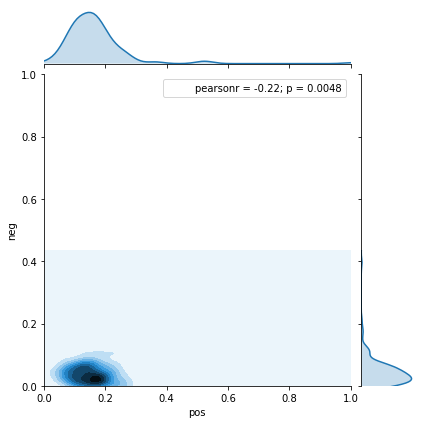

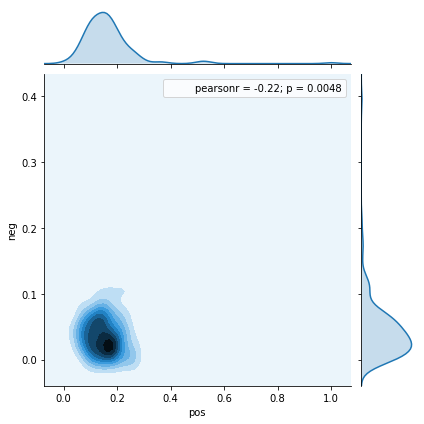

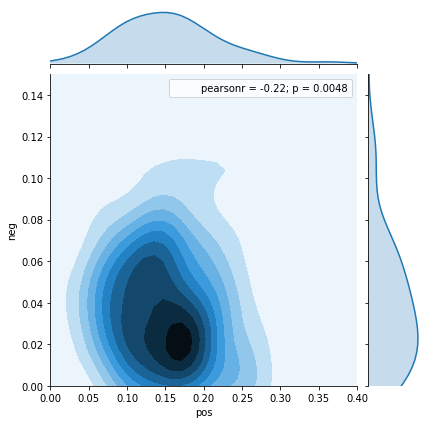

In [7]:
p = sns.jointplot(x="pos", y="neg", data=sentiments_df, kind="kde")
p.ax_joint.set_xlim(0,1)
p.ax_joint.set_ylim(0,1)
plt.show()

p = sns.jointplot(x="pos", y="neg", data=sentiments_df, kind="kde")
plt.show()

p = sns.jointplot(x="pos", y="neg", data=sentiments_df, kind="kde")
p.ax_joint.set_xlim(0,0.4)
p.ax_joint.set_ylim(0,0.15)
plt.show()

This is not so informative, let's move on to topic modeling.

# Topic modeling

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

## Remove mid-word punctuation

All other punctuation is handled by the tokenizer.

In [9]:
comment_column = feedback.iloc[:, 0]
comment_column = [x.replace("'", "") for x in comment_column]
comment_column = [x.replace("-", "") for x in comment_column]

## TFIDF + NMF

TFIDF: Term frequency - inverse document frequency

NMF: Non-negative matrix factorization

### Transform dataset to counts

In [10]:
max_features = 1000
tfidf_vec = TfidfVectorizer(max_df=0.95, min_df=2,
                            max_features=max_features, stop_words="english")
tfidf = tfidf_vec.fit_transform(comment_column)
tfidf_feats = tfidf_vec.get_feature_names()

### Run NMF

Have to specify #/topics a priori.

In [11]:
n_topics = 10
nmf = NMF(n_components=n_topics, random_state=0, init="nndsvd")
nmf = nmf.fit(tfidf)

In [12]:
for topic_idx, topic in enumerate(nmf.components_):
    print "Topic %d:" % (topic_idx)
    print " ".join([tfidf_feats[i]
                    for i in topic.argsort()[:-10 - 1:-1]])

Topic 0:
climate change conversation mom opinions dad family issues people topic
Topic 1:
warming global think future class members general issue topic family
Topic 2:
friends talked lighthearted conversation quite felt talking pretty kind changing
Topic 3:
humorous family members bit conversation talked perspectives immediate pretty dinner
Topic 4:
started friend talking got deep sad little thanksgiving forced better
Topic 5:
fun teammates educated wasnt conversation topic lighthearted tone arent chose
Topic 6:
discussion opinion app subject anticipated turns impressive ideas friends turned
Topic 7:
conversations really topics think feel just did app use went
Topic 8:
questions question asked answer answers didnt time events said parents
Topic 9:
natural disasters affect different interesting realize world happen hurricane understanding


## Count vectorization + LDA

LDA: Latent Dirichlet allocation

### Transform dataset to counts

In [13]:
tf_vec = CountVectorizer(max_df=0.95, min_df=2,
                         max_features=max_features, stop_words="english")
tf = tf_vec.fit_transform(comment_column)
tf_feats = tf_vec.get_feature_names()

### Run LDA

In [14]:
lda = LatentDirichletAllocation(
    n_topics=n_topics, learning_method="online", random_state=0)
lda = lda.fit(tf)

### Output topic clusters

In [15]:
for topic_idx, topic in enumerate(lda.components_):
    print "Topic %d:" % (topic_idx)
    print " ".join([tf_feats[i]
                    for i in topic.argsort()[:-10 - 1:-1]])

Topic 0:
places sea level points things logical focus round addressed paragraph
Topic 1:
climate family lighthearted conversation change questions dad talked way pollution
Topic 2:
events energy passion didn strong devastating republican 20 solutions happened
Topic 3:
warming global subject discussion conversation times family humans members filled
Topic 4:
sea intellectual calm gathered mean getting winters barely discussion keeping
Topic 5:
conversations climate think different conversation change global certain interesting questions
Topic 6:
person language asked river atm point 111 interviewed wasnt questions
Topic 7:
water sisters long dams environmental rivers northern holiday dads india
Topic 8:
conversation friends climate family questions change warming global lighthearted think
Topic 9:
brothers conservation nice created round periods proposed strong kept excited


# Sentence clustering

In [16]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

## Fit the model & predict clusters

In [17]:
n_components = 100
svd = TruncatedSVD(n_components=n_components)
norm = Normalizer(copy=False)
lsa = make_pipeline(svd, norm)

tfidf_norm = lsa.fit_transform(tfidf)

n_clusters = 15
km = KMeans(n_clusters=n_clusters, n_init=5)
clusters = km.fit_predict(tfidf_norm)

## Find top words in each cluster

In [18]:
unordered_centroids = svd.inverse_transform(km.cluster_centers_)
ordered_centroids = unordered_centroids.argsort()[:, ::-1]

In [19]:
for cluster_i in range(n_clusters):
    rows = np.where(clusters == cluster_i)[0]
    print "---------- Cluster %d ---------\n" % cluster_i
    print "Most important words: ", " ".join([tf_feats[i] for i in ordered_centroids[cluster_i, :8]])
    print "#/comments in cluster: ", len(rows)
    print ""
    for row in rows:
        comment = feedback.iloc[row, 0]
        print "\t * ", comment, "\n"
    print "\n\n"

---------- Cluster 0 ---------

Most important words:  change family climate conversation questions members opinions issue
#/comments in cluster:  12

	 *  Over the holiday break, I convinced my family to try the app on the evening of Thanksgiving. I interviewed my father (Jon, 54), mother (Melonie, 54), and brother (Luke, 21). I have ten of my fifteen credits dedicated to the topic of climate change (ATM S 111 and ENGL 199) so this is a topic that I feel strongly about even though my family isn't exposed to it in the slightest way. 

I was tentative going into the conversation because I know that my family doesn't have the same views on science that I do; "Christians tend to deny climate change and accept that everything happens for a reason." I was pleasantly surprised to find that the questions asked steered the conversation in a gentle and unbiased way. It was easier for my family to answer questions honestly rather than being wary about their answer being pushed in one direction. 

---

# Try this on individual sentences instead of whole comments

## Transform the data into individual sentences

In [20]:
import re

In [21]:
comment_column = feedback.iloc[:,0]
comment_sentences = []
for comment in comment_column:
    split = re.split(r"\.|\?|\!", comment)
    split = [" ".join(s.split()) for s in split]
    if "" in split:
        split.remove("")
    comment_sentences.extend(split)

## NLTK

### Compute the sentiment and output a data frame

In [22]:
sia = SentimentIntensityAnalyzer()
sentiments = np.zeros((len(comment_sentences), 3))
for comment_i, comment in enumerate(comment_sentences):
    ss = sia.polarity_scores(comment)
    s = [ss.get("pos"), ss.get("neu"), ss.get("neg")]
    sentiments[comment_i] = s
sentiments_df = pd.DataFrame(data=sentiments, columns=["pos", "neu", "neg"])

## Visualize the distribution of positive vs negative

Things to look for:

* Is it more positive or negative?
* Are there multiple clusters?

Keep in mind that there is a 3rd option (neutral) that is not represented here.

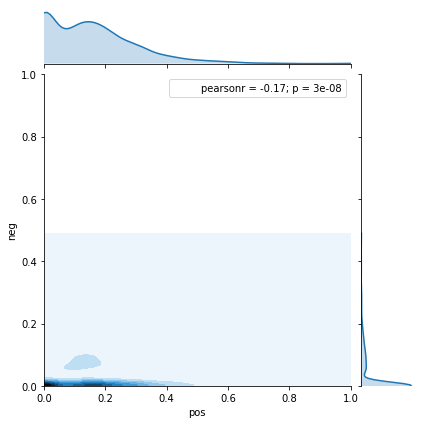

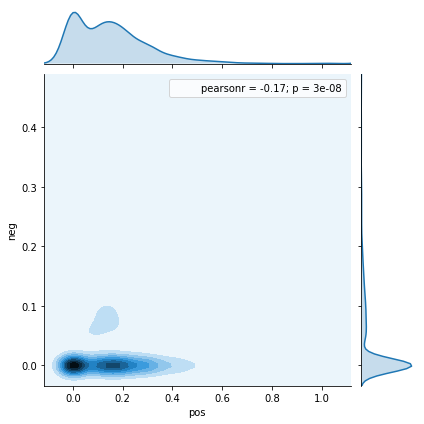

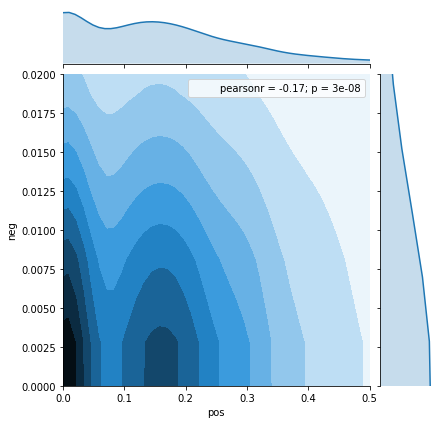

In [23]:
p = sns.jointplot(x="pos", y="neg", data=sentiments_df, kind="kde")
p.ax_joint.set_xlim(0,1)
p.ax_joint.set_ylim(0,1)
plt.show()

p = sns.jointplot(x="pos", y="neg", data=sentiments_df, kind="kde")
plt.show()

p = sns.jointplot(x="pos", y="neg", data=sentiments_df, kind="kde")
p.ax_joint.set_xlim(0,0.5)
p.ax_joint.set_ylim(0,0.02)
plt.show()

This is showing that most of the individual sentences are quite neutral or positive.

## Topic modeling

### Remove mid-word punctuation

All other punctuation is handled by the tokenizer.

In [24]:
comment_sentences = [x.replace("'", "") for x in comment_sentences]
comment_sentences = [x.replace("-", "") for x in comment_sentences]

### TFIDF + NMF

#### Transform dataset to counts

In [25]:
max_features = 1000
tfidf_vec = TfidfVectorizer(max_df=0.95, min_df=2,
                            max_features=max_features, stop_words="english")
tfidf = tfidf_vec.fit_transform(comment_sentences)
tfidf_feats = tfidf_vec.get_feature_names()

#### Run NMF

Have to specify #/topics a priori.

In [26]:
n_topics = 10
nmf = NMF(n_components=n_topics, random_state=0, init="nndsvd")
nmf = nmf.fit(tfidf)

In [27]:
for topic_idx, topic in enumerate(nmf.components_):
    print "Topic %d:" % (topic_idx)
    print " ".join([tfidf_feats[i]
                    for i in topic.argsort()[:-10 - 1:-1]])

Topic 0:
conversation pretty went overall times parents humorous wasnt interesting brother
Topic 1:
climate change topic lot different interested opinions mom did dad
Topic 2:
family members talking thanksgiving immediate dad game app friend close
Topic 3:
went conversations really pretty fairly smoothly topics great think quite
Topic 4:
friends talking people age played good reason help kind teammates
Topic 5:
lighthearted pretty topics got quite humorous began good initially seriously
Topic 6:
questions asked answer question really lot app think didnt got
Topic 7:
global warming people really topic issues opinions different future care
Topic 8:
fun time discussion turned overall really educational discuss knew discussions
Topic 9:
talked group friends topics sister pretty ideas issues class brother


### Count vectorization + LDA
#### Transform dataset to counts

In [28]:
tf_vec = CountVectorizer(max_df=0.95, min_df=2,
                         max_features=max_features, stop_words="english")
tf = tf_vec.fit_transform(comment_sentences)
tf_feats = tf_vec.get_feature_names()

#### Run LDA

In [29]:
lda = LatentDirichletAllocation(
    n_topics=n_topics, learning_method="online", random_state=0)
lda = lda.fit(tf)

#### Output topic clusters

In [30]:
for topic_idx, topic in enumerate(lda.components_):
    print "Topic %d:" % (topic_idx)
    print " ".join([tf_feats[i]
                    for i in topic.argsort()[:-10 - 1:-1]])

Topic 0:
talking grow friends family climate people believe change know dont
Topic 1:
friends topic talked did interesting conversation different think people want
Topic 2:
climate change family like issues long just lot opinions think
Topic 3:
global warming really earth kids seriously able questions family consider
Topic 4:
great way best roommates easier hard answer awkward main initially
Topic 5:
different ages expected home decided told dinner extra assignment greater
Topic 6:
conversation lighthearted fun humorous pretty went really quite questions topics
Topic 7:
family members conversation talked natural disasters level example sea playing
Topic 8:
app family mom brother dad sister thanksgiving close friends younger
Topic 9:
questions conversation discussion answer question went knew easy gave light


## Sentence clustering

### Fit the model & predict clusters

In [31]:
n_components = 100
svd = TruncatedSVD(n_components=n_components)
norm = Normalizer(copy=False)
lsa = make_pipeline(svd, norm)

tfidf_norm = lsa.fit_transform(tfidf)

n_clusters = 50
km = KMeans(n_clusters=n_clusters, n_init=5)
clusters = km.fit_predict(tfidf_norm)

### Find top words in each cluster

In [32]:
unordered_centroids = svd.inverse_transform(km.cluster_centers_)
ordered_centroids = unordered_centroids.argsort()[:, ::-1]

In [34]:
for cluster_i in range(n_clusters):
    rows = np.where(clusters == cluster_i)[0]
    print "---------- Cluster %d ---------\n" % cluster_i
    print "Most important words: ", " ".join([tf_feats[i] for i in ordered_centroids[cluster_i, :8]])
    print "#/comments in cluster: ", len(rows)
    print ""

---------- Cluster 0 ---------

Most important words:  planet future concerned going impact affect does care
#/comments in cluster:  9

---------- Cluster 1 ---------

Most important words:  age interesting played different person time related cousins
#/comments in cluster:  15

---------- Cluster 2 ---------

Most important words:  game playing played people family play conversation lighthearted
#/comments in cluster:  16

---------- Cluster 3 ---------

Most important words:  knowledge climate change family members background interesting talking
#/comments in cluster:  9

---------- Cluster 4 ---------

Most important words:  topic climate change interested did family conversation opinions
#/comments in cluster:  27

---------- Cluster 5 ---------

Most important words:  lighthearted conversation humorous quite topics mom began relatively
#/comments in cluster:  25

---------- Cluster 6 ---------

Most important words:  went talking friends conversation mom lighthearted smoothly carb

In [33]:
for cluster_i in range(n_clusters):
    rows = np.where(clusters == cluster_i)[0]
    print "---------- Cluster %d ---------\n" % cluster_i
    print "Most important words: ", " ".join([tf_feats[i] for i in ordered_centroids[cluster_i, :8]])
    print "#/comments in cluster: ", len(rows)
    print ""
    for row in rows:
        sentence = comment_sentences[row].strip()
        print "\t * ", sentence, "\n"
    print "\n\n"

---------- Cluster 0 ---------

Most important words:  planet future concerned going impact affect does care
#/comments in cluster:  9

	 *  It is nice to know that there are people who care as much as I do when it comes to saving our planet, or at least impacting it, before our death 

	 *  It does have an impact on us and in our society 

	 *  He is very concerned about what is going to affect the future of planet and how 

	 *  He is worried about what the outcome of the planet will be 

	 *  The conversation was serious in that we were all concerned about the future of global warming and how it is going to impact all of us and our future children 

	 *  He does not want us to live in a planet that is in a worse state than how it was when he was young 

	 *  In general, it wasnt particularly humorous or fun because we are all quite concerned about the future of the planet 

	 *  After all, this is the future of the planet we’re talking about 

	 *  At others times there was concerne

	 *  This would mean the possibility of all of my friends and their families having to leave our hometown 

	 *  I was talking to friends/teammates 

	 *  Another reason why is that I was talking with friends 

	 *  I was talking with my friends that go to The University of Washington 

	 *  I was talking with three friends that also go here 

	 *  Our conversations were mainly lighthearted because I was talking to some of my fellow friends, but in some cases they really began to reflect on the consequences that could face us in the future 

	 *  I think if I was talking to my friends or strangers the conversation would have gone a lot differently 

	 *  If I was talking to my friends I think there would be a lot more agreement and thinking about what we can do as a generation to help the planet instead of just arguing about whether or not climate change even exists or not 




---------- Cluster 9 ---------

Most important words:  conversations topics lighthearted climate app differen


	 *  This could have led to some bias affecting how seriously we took each question, but I felt that we had meaningful, serious discussion about the topics 

	 *  We joked around about our experiences and told stories that things that happened to us that related to the question 

	 *  Also, for lighthearted question, we searched up Google on stuff in order to understand the topic 

	 *  We would counterargue each other and feel comfortable in doing so 

	 *  There was a question about the average surface temperature of the Earth becoming warmer, and if winters feel different than they used to 

	 *  (I submitted one previously but I by accident did not follow the rubric for at least 23 paragraph each question 

	 *  So I decide the submit this one which has longer answers for each question 

	 *  An example of keeping the conversation serious was our discussion of whether winters feel different 

	 *  This topic came up in our discussion because the winters in the Bay Area do feel dif

	 *  The conversation went pretty smoothly 

	 *  The conversation went very quickly as my family was rushing me through the assignment and trying to keep my dad from flaring up 

	 *  In general, my conversation went well 

	 *  In the conversation, it went different ways depending on the type of question that was discussed 

	 *  Our conversation went okay 

	 *  There were some questions that we couldnt really relate to so we quickly answered that question and went on to the next one 

	 *  It was only when we went off topics that it became lighthearted 

	 *  It was alright 

	 *  It went pretty well 

	 *  My conversation went well 

	 *  I feel that our conversation went pretty serious 

	 *  The conversation went ok with most of the people 

	 *  I think the conversation went well and since my family is composed of very nice individuals, they were more than willing to participate in proactive conversation 

	 *  The conversation went on smoothly thanks to the logical design of t